In [19]:
#not sure why we need to define these

def custom_transition_func(p):

    _T = transition_matrix(N=N, M=M, p=p, absorbing_states=goal_states)
    _T = insert_walls_into_T(T=_T, wall_indices=wall_states)
    return _T

def custom_gamma_func(gamma):
    return gamma

def custom_reward_func(big_reward_1, big_reward_2):
    reward_func = np.zeros((N, M))
    reward_func[N-1, 0] = big_reward_1
    reward_func[0,M-1] = big_reward_2
    # reward_func[N-1, M-1] = big_reward_3
    return reward_func.flatten()

In [145]:
import os, pickle
import numpy as np

import matplotlib.pyplot as plt


curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

def load_checkpoints(directories):

    all_checkpoints = {}

    for directory in directories:
    
        checkpoints = []
        for root, dirs, files in os.walk(directory):
            for filename in files:
                filepath = os.path.join(root, filename)
                with open(filepath, "rb") as file:
                    checkpoint = pickle.load(file)
                    checkpoints.append(checkpoint)

        all_checkpoints[os.path.basename(directory)] = checkpoints
    return all_checkpoints



In [146]:
dir_0606 = ["checkpoints/medium_maze/Rtrue=[[0.6], [0.6]]/AMBER", "checkpoints/medium_maze/Rtrue=[[0.6], [0.6]]/BIRL", "checkpoints/medium_maze/Rtrue=[[0.6], [0.6]]/ED-BIRL"]
dir_0804 = ["checkpoints/medium_maze/Rtrue=[[0.8], [0.4]]/AMBER", "checkpoints/medium_maze/Rtrue=[[0.8], [0.4]]/BIRL", "checkpoints/medium_maze/Rtrue=[[0.8], [0.4]]/ED-BIRL"]
dir_0903 = ["checkpoints/medium_maze/Rtrue=[[0.9], [0.3]]/AMBER", "checkpoints/medium_maze/Rtrue=[[0.9], [0.3]]/BIRL", "checkpoints/medium_maze/Rtrue=[[0.9], [0.3]]/ED-BIRL"]
dir_0906 = ["checkpoints/medium_maze/Rtrue=[[0.9], [0.6]]/AMBER", "checkpoints/medium_maze/Rtrue=[[0.9], [0.6]]/BIRL", "checkpoints/medium_maze/Rtrue=[[0.9], [0.6]]/ED-BIRL"]
dir_09039 = ["checkpoints/medium_maze/Rtrue=[[0.9], [0.39]]/AMBER", "checkpoints/medium_maze/Rtrue=[[0.9], [0.39]]/BIRL", "checkpoints/medium_maze/Rtrue=[[0.9], [0.39]]/ED-BIRL"]


results_0606 = load_checkpoints(dir_0606)
results_0804 = load_checkpoints(dir_0804)
results_0903 = load_checkpoints(dir_0903)
results_0906 = load_checkpoints(dir_0906)
results_09039 = load_checkpoints(dir_09039)


In [147]:
import numpy as np

def load_ratios(results_dict):

    mean_ratios = {}
    var_ratios = {}

    for method_name, result in results_dict.items():

        mean_params = np.array(result[0]["diagnostics"]["parameter_means"])
        _n_episodes = mean_params.shape[0]
        _n_parameters = mean_params.shape[1]
        _n_results = len(result)
        mean_params = np.zeros((_n_episodes, _n_parameters, _n_results))
        for idx, result in enumerate(result):
            mean_params[:,:,idx] = np.array(result["diagnostics"]["parameter_means"])

        ratios = mean_params[:,0,:]/mean_params[:,-1,:]
        mean_ratio = np.mean(ratios, axis=1)
        var_ratio = np.var(ratios, axis=1)

        # Insert column of zeros and ones for prior
        mean_ratio = np.insert(mean_ratio, 0, 1, axis=0)
        var_ratio = np.insert(var_ratio, 0, 0, axis=0)

        mean_ratios[method_name] = mean_ratio
        var_ratios[method_name] = var_ratio

    true_ratio = result["user_params"].R[0]/result["user_params"].R[-1]

    return mean_ratios, var_ratios, true_ratio

mean_ratios_0606, var_ratios_0606, true_ratio_0606 = load_ratios(results_0606)
mean_ratios_0804, var_ratios_0804, true_ratio_0804 = load_ratios(results_0804)
mean_ratios_0903, var_ratios_0903, true_ratio_0903 = load_ratios(results_0903)
mean_ratios_09039, var_ratios_09039, true_ratio_09039 = load_ratios(results_09039)
mean_ratios_0906, var_ratios_0906, true_ratio_0906 = load_ratios(results_0906)


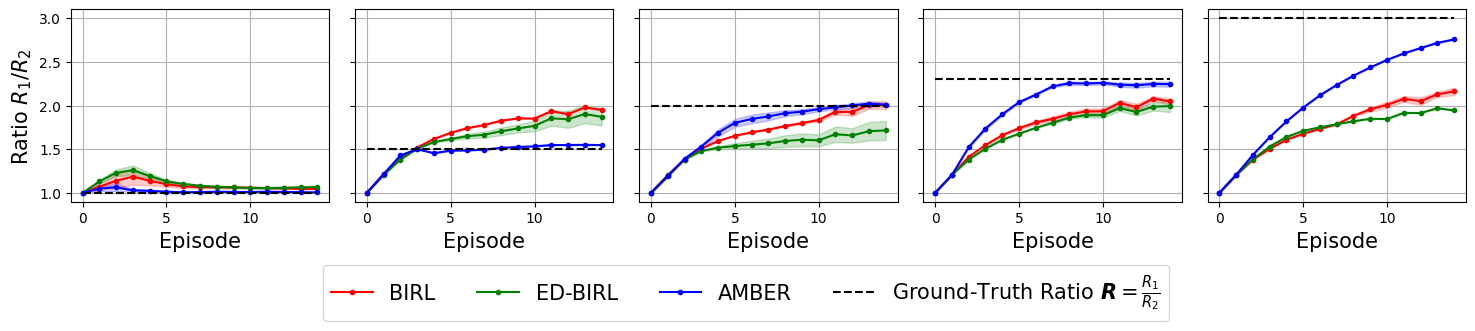

In [191]:
fontsize = 15
yshift_legend = 0.1

fig, axs = plt.subplots(1,5, figsize=(18,2.5), sharey=True)
plt.subplots_adjust(wspace=0.1)

axs[0].plot(mean_ratios_0606["BIRL"], "r.-", label="BIRL")
axs[0].plot(mean_ratios_0606["ED-BIRL"], "g.-", label="ED-BIRL")
axs[0].plot(mean_ratios_0606["AMBER"], "b.-", label="AMBER")
axs[0].fill_between(range(15), mean_ratios_0606["AMBER"] - var_ratios_0606["AMBER"], mean_ratios_0606["AMBER"] + var_ratios_0606["AMBER"], color="blue", alpha=0.2)
axs[0].fill_between(range(15), mean_ratios_0606["BIRL"] - var_ratios_0606["BIRL"], mean_ratios_0606["BIRL"] + var_ratios_0606["BIRL"], color="red", alpha=0.2)
axs[0].fill_between(range(15), mean_ratios_0606["ED-BIRL"] - var_ratios_0606["ED-BIRL"], mean_ratios_0606["ED-BIRL"] + var_ratios_0606["ED-BIRL"], color="green", alpha=0.2)
axs[0].hlines(true_ratio_0606, 0, 14, colors="black", linestyles="--", label = r"Ground-Truth Ratio $\boldsymbol{R} = \frac{R_1}{R_2}$")
axs[0].set_xlabel("Episode", fontsize=fontsize)
axs[0].set_ylabel("Ratio $R_1/R_2$", fontsize=fontsize)
axs[0].grid()


axs[1].plot(mean_ratios_0906["BIRL"], "r.-")
axs[1].plot(mean_ratios_0906["ED-BIRL"], "g.-")
axs[1].plot(mean_ratios_0906["AMBER"], "b.-")
axs[1].fill_between(range(15), mean_ratios_0906["AMBER"] - var_ratios_0906["AMBER"], mean_ratios_0906["AMBER"] + var_ratios_0906["AMBER"], color="blue", alpha=0.2)
axs[1].fill_between(range(15), mean_ratios_0906["BIRL"] - var_ratios_0906["BIRL"], mean_ratios_0906["BIRL"] + var_ratios_0906["BIRL"], color="red", alpha=0.2)
axs[1].fill_between(range(15), mean_ratios_0906["ED-BIRL"] - var_ratios_0906["ED-BIRL"], mean_ratios_0906["ED-BIRL"] + var_ratios_0906["ED-BIRL"], color="green", alpha=0.2)
axs[1].hlines(true_ratio_0906, 0, 14, colors="black", linestyles="--")
axs[1].set_xlabel("Episode", fontsize=fontsize)
axs[1].grid()


axs[2].plot(mean_ratios_0804["BIRL"], "r.-")
axs[2].plot(mean_ratios_0804["ED-BIRL"], "g.-")
axs[2].plot(mean_ratios_0804["AMBER"], "b.-")
axs[2].fill_between(range(15), mean_ratios_0804["AMBER"] - var_ratios_0804["AMBER"], mean_ratios_0804["AMBER"] + var_ratios_0804["AMBER"], color="blue", alpha=0.2)
axs[2].fill_between(range(15), mean_ratios_0804["BIRL"] - var_ratios_0804["BIRL"], mean_ratios_0804["BIRL"] + var_ratios_0804["BIRL"], color="red", alpha=0.2)
axs[2].fill_between(range(15), mean_ratios_0804["ED-BIRL"] - var_ratios_0804["ED-BIRL"], mean_ratios_0804["ED-BIRL"] + var_ratios_0804["ED-BIRL"], color="green", alpha=0.2)
axs[2].hlines(true_ratio_0804, 0, 14, colors="black", linestyles="--")
axs[2].set_xlabel("Episode", fontsize=fontsize)
axs[2].grid()

axs[3].plot(mean_ratios_09039["BIRL"], "r.-")
axs[3].plot(mean_ratios_09039["ED-BIRL"], "g.-")
axs[3].plot(mean_ratios_09039["AMBER"], "b.-")
axs[3].fill_between(range(15), mean_ratios_09039["AMBER"] - var_ratios_09039["AMBER"], mean_ratios_09039["AMBER"] + var_ratios_09039["AMBER"], color="blue", alpha=0.2)
axs[3].fill_between(range(15), mean_ratios_09039["BIRL"] - var_ratios_09039["BIRL"], mean_ratios_09039["BIRL"] + var_ratios_09039["BIRL"], color="red", alpha=0.2)
axs[3].fill_between(range(15), mean_ratios_09039["ED-BIRL"] - var_ratios_09039["ED-BIRL"], mean_ratios_09039["ED-BIRL"] + var_ratios_09039["ED-BIRL"], color="green", alpha=0.2)
axs[3].hlines(true_ratio_09039, 0, 14, colors="black", linestyles="--")
axs[3].set_xlabel("Episode", fontsize=fontsize)
axs[3].grid()


axs[4].plot(mean_ratios_0903["BIRL"], "r.-")
axs[4].plot(mean_ratios_0903["ED-BIRL"], "g.-")
axs[4].plot(mean_ratios_0903["AMBER"], "b.-")
axs[4].fill_between(range(15), mean_ratios_0903["AMBER"] - var_ratios_0903["AMBER"], mean_ratios_0903["AMBER"] + var_ratios_0903["AMBER"], color="blue", alpha=0.2)
axs[4].fill_between(range(15), mean_ratios_0903["BIRL"] - var_ratios_0903["BIRL"], mean_ratios_0903["BIRL"] + var_ratios_0903["BIRL"], color="red", alpha=0.2)
axs[4].fill_between(range(15), mean_ratios_0903["ED-BIRL"] - var_ratios_0903["ED-BIRL"], mean_ratios_0903["ED-BIRL"] + var_ratios_0903["ED-BIRL"], color="green", alpha=0.2)
axs[4].hlines(true_ratio_0903, 0, 14, colors="black", linestyles="--")
axs[4].set_xlabel("Episode", fontsize=fontsize)
axs[4].grid()

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -yshift_legend), ncols = 4, fontsize=fontsize)


## Get Values for table

In [113]:
def get_ROI_sizes(results_dict):

    mean_ROI_sizes = {}
    var_ROI_sizes = {}

    for method_name, result in results_dict.items():

        _one_ROI = np.array(result[0]["diagnostics"]["ROI_sizes"])
        _n_episodes = _one_ROI.shape[0]
        _n_results = len(result)
        ROI_sizes = np.zeros((_n_episodes, _n_results))

        for idx, result in enumerate(result):
            
            ROI_sizes[:,idx] = np.array(result["diagnostics"]["ROI_sizes"])

        mean_ROI = np.mean(ROI_sizes, axis=1)
        var_ROI = np.var(ROI_sizes, axis=1)

        mean_ROI_sizes[method_name] = mean_ROI
        var_ROI_sizes[method_name] = var_ROI
    return mean_ROI_sizes, var_ROI_sizes

In [130]:
mean_ROI_size_0606, var_ROI_size_0606 = get_ROI_sizes(results_0606)
mean_ROI_size_0804, var_ROI_size_0804 = get_ROI_sizes(results_0804)
mean_ROI_size_0903, var_ROI_size_0903 = get_ROI_sizes(results_0903)
mean_ROI_size_09039, var_ROI_size_09039 = get_ROI_sizes(results_09039)
mean_ROI_size_0906, var_ROI_size_0906 = get_ROI_sizes(results_0906)

ROI_CI_decrease = [0.6*0.8**i for i in range(15)]
ROI_halfing = [0.6*0.5**i for i in range(15)]

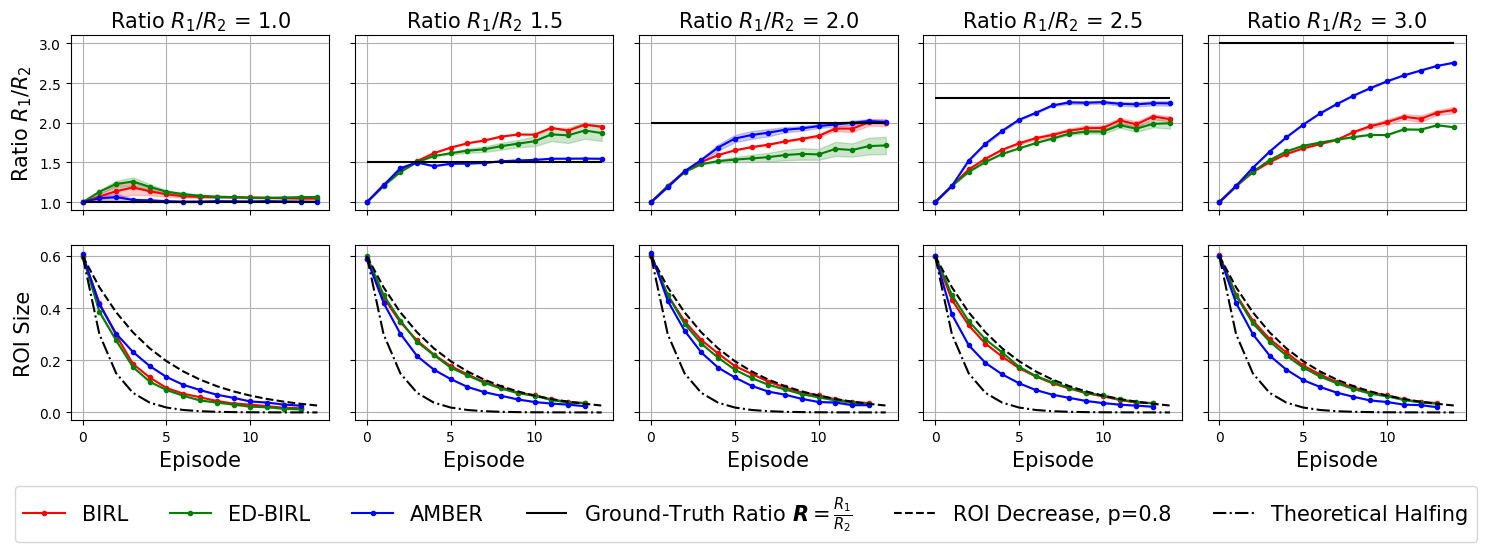

In [205]:
fig, axs = plt.subplots(2,5, figsize=(18,5), sharey="row", sharex="col")
plt.subplots_adjust(wspace=0.1)

fontsize = 15
yshift_legend = 0

axs[0,0].set_title("Ratio $R_1/R_2$ = 1.0", fontsize=fontsize)
axs[0,0].plot(mean_ratios_0606["BIRL"], "r.-", label="BIRL")
axs[0,0].plot(mean_ratios_0606["ED-BIRL"], "g.-", label="ED-BIRL")
axs[0,0].plot(mean_ratios_0606["AMBER"], "b.-", label="AMBER")
axs[0,0].fill_between(range(15), mean_ratios_0606["AMBER"] - var_ratios_0606["AMBER"], mean_ratios_0606["AMBER"] + var_ratios_0606["AMBER"], color="blue", alpha=0.2)
axs[0,0].fill_between(range(15), mean_ratios_0606["BIRL"] - var_ratios_0606["BIRL"], mean_ratios_0606["BIRL"] + var_ratios_0606["BIRL"], color="red", alpha=0.2)
axs[0,0].fill_between(range(15), mean_ratios_0606["ED-BIRL"] - var_ratios_0606["ED-BIRL"], mean_ratios_0606["ED-BIRL"] + var_ratios_0606["ED-BIRL"], color="green", alpha=0.2)
axs[0,0].hlines(true_ratio_0606, 0, 14, colors="black", linestyles="-", label = r"Ground-Truth Ratio $\boldsymbol{R} = \frac{R_1}{R_2}$")
axs[0,0].set_ylabel("Ratio $R_1/R_2$", fontsize=fontsize)
axs[0,0].grid()

axs[0,1].set_title("Ratio $R_1/R_2$ = 1.5", fontsize=fontsize)
axs[0,1].plot(mean_ratios_0906["BIRL"], "r.-")
axs[0,1].plot(mean_ratios_0906["ED-BIRL"], "g.-")
axs[0,1].plot(mean_ratios_0906["AMBER"], "b.-")
axs[0,1].fill_between(range(15), mean_ratios_0906["AMBER"] - var_ratios_0906["AMBER"], mean_ratios_0906["AMBER"] + var_ratios_0906["AMBER"], color="blue", alpha=0.2)
axs[0,1].fill_between(range(15), mean_ratios_0906["BIRL"] - var_ratios_0906["BIRL"], mean_ratios_0906["BIRL"] + var_ratios_0906["BIRL"], color="red", alpha=0.2)
axs[0,1].fill_between(range(15), mean_ratios_0906["ED-BIRL"] - var_ratios_0906["ED-BIRL"], mean_ratios_0906["ED-BIRL"] + var_ratios_0906["ED-BIRL"], color="green", alpha=0.2)
axs[0,1].hlines(true_ratio_0906, 0, 14, colors="black", linestyles="-")
axs[0,1].grid()

axs[0,2].set_title("Ratio $R_1/R_2$ = 2.0", fontsize=fontsize)
axs[0,2].plot(mean_ratios_0804["BIRL"], "r.-")
axs[0,2].plot(mean_ratios_0804["ED-BIRL"], "g.-")
axs[0,2].plot(mean_ratios_0804["AMBER"], "b.-")
axs[0,2].fill_between(range(15), mean_ratios_0804["AMBER"] - var_ratios_0804["AMBER"], mean_ratios_0804["AMBER"] + var_ratios_0804["AMBER"], color="blue", alpha=0.2)
axs[0,2].fill_between(range(15), mean_ratios_0804["BIRL"] - var_ratios_0804["BIRL"], mean_ratios_0804["BIRL"] + var_ratios_0804["BIRL"], color="red", alpha=0.2)
axs[0,2].fill_between(range(15), mean_ratios_0804["ED-BIRL"] - var_ratios_0804["ED-BIRL"], mean_ratios_0804["ED-BIRL"] + var_ratios_0804["ED-BIRL"], color="green", alpha=0.2)
axs[0,2].hlines(true_ratio_0804, 0, 14, colors="black", linestyles="-")
axs[0,2].grid()

axs[0,3].set_title("Ratio $R_1/R_2$ = 2.5", fontsize=fontsize)
axs[0,3].plot(mean_ratios_09039["BIRL"], "r.-")
axs[0,3].plot(mean_ratios_09039["ED-BIRL"], "g.-")
axs[0,3].plot(mean_ratios_09039["AMBER"], "b.-")
axs[0,3].fill_between(range(15), mean_ratios_09039["AMBER"] - var_ratios_09039["AMBER"], mean_ratios_09039["AMBER"] + var_ratios_09039["AMBER"], color="blue", alpha=0.2)
axs[0,3].fill_between(range(15), mean_ratios_09039["BIRL"] - var_ratios_09039["BIRL"], mean_ratios_09039["BIRL"] + var_ratios_09039["BIRL"], color="red", alpha=0.2)
axs[0,3].fill_between(range(15), mean_ratios_09039["ED-BIRL"] - var_ratios_09039["ED-BIRL"], mean_ratios_09039["ED-BIRL"] + var_ratios_09039["ED-BIRL"], color="green", alpha=0.2)
axs[0,3].hlines(true_ratio_09039, 0, 14, colors="black", linestyles="-")
axs[0,3].grid()

axs[0,4].set_title("Ratio $R_1/R_2$ = 3.0", fontsize=fontsize)
axs[0,4].plot(mean_ratios_0903["BIRL"], "r.-")
axs[0,4].plot(mean_ratios_0903["ED-BIRL"], "g.-")
axs[0,4].plot(mean_ratios_0903["AMBER"], "b.-")
axs[0,4].fill_between(range(15), mean_ratios_0903["AMBER"] - var_ratios_0903["AMBER"], mean_ratios_0903["AMBER"] + var_ratios_0903["AMBER"], color="blue", alpha=0.2)
axs[0,4].fill_between(range(15), mean_ratios_0903["BIRL"] - var_ratios_0903["BIRL"], mean_ratios_0903["BIRL"] + var_ratios_0903["BIRL"], color="red", alpha=0.2)
axs[0,4].fill_between(range(15), mean_ratios_0903["ED-BIRL"] - var_ratios_0903["ED-BIRL"], mean_ratios_0903["ED-BIRL"] + var_ratios_0903["ED-BIRL"], color="green", alpha=0.2)
axs[0,4].hlines(true_ratio_0903, 0, 14, colors="black", linestyles="-")
axs[0,4].grid()

axs[1,0].plot(mean_ROI_size_0606["BIRL"], "r.-")
axs[1,0].plot(mean_ROI_size_0606["ED-BIRL"], "g.-")
axs[1,0].plot(mean_ROI_size_0606["AMBER"], "b.-")
axs[1,0].plot(ROI_CI_decrease, "k--", label="ROI Decrease, p=0.8")
axs[1,0].plot(ROI_halfing, "k-.", label="Theoretical Halfing")
axs[1,0].fill_between(range(14), mean_ROI_size_0606["AMBER"] - var_ROI_size_0606["AMBER"], mean_ROI_size_0606["AMBER"] + var_ROI_size_0606["AMBER"], color="blue", alpha=0.2)
axs[1,0].fill_between(range(14), mean_ROI_size_0606["BIRL"] - var_ROI_size_0606["BIRL"], mean_ROI_size_0606["BIRL"] + var_ROI_size_0606["BIRL"], color="red", alpha=0.2)
axs[1,0].fill_between(range(14), mean_ROI_size_0606["ED-BIRL"] - var_ROI_size_0606["ED-BIRL"], mean_ROI_size_0606["ED-BIRL"] + var_ROI_size_0606["ED-BIRL"], color="green", alpha=0.2)
axs[1,0].set_xlabel("Episode", fontsize=fontsize)
axs[1,0].set_ylabel("ROI Size", fontsize=fontsize)
axs[1,0].grid()

axs[1,1].plot(mean_ROI_size_0906["BIRL"], "r.-")
axs[1,1].plot(mean_ROI_size_0906["ED-BIRL"], "g.-")
axs[1,1].plot(mean_ROI_size_0906["AMBER"], "b.-")
axs[1,1].plot(ROI_CI_decrease, "k--")
axs[1,1].plot(ROI_halfing, "k-.")
axs[1,1].fill_between(range(14), mean_ROI_size_0906["AMBER"] - var_ROI_size_0906["AMBER"], mean_ROI_size_0906["AMBER"] + var_ROI_size_0906["AMBER"], color="blue", alpha=0.2)
axs[1,1].fill_between(range(14), mean_ROI_size_0906["BIRL"] - var_ROI_size_0906["BIRL"], mean_ROI_size_0906["BIRL"] + var_ROI_size_0906["BIRL"], color="red", alpha=0.2)
axs[1,1].fill_between(range(14), mean_ROI_size_0906["ED-BIRL"] - var_ROI_size_0906["ED-BIRL"], mean_ROI_size_0906["ED-BIRL"] + var_ROI_size_0906["ED-BIRL"], color="green", alpha=0.2)
axs[1,1].set_xlabel("Episode", fontsize=fontsize)
axs[1,1].grid()

axs[1,2].plot(mean_ROI_size_0804["BIRL"], "r.-")
axs[1,2].plot(mean_ROI_size_0804["ED-BIRL"], "g.-")
axs[1,2].plot(mean_ROI_size_0804["AMBER"], "b.-")
axs[1,2].plot(ROI_CI_decrease, "k--")
axs[1,2].plot(ROI_halfing, "k-.")
axs[1,2].fill_between(range(14), mean_ROI_size_0804["AMBER"] - var_ROI_size_0804["AMBER"], mean_ROI_size_0804["AMBER"] + var_ROI_size_0804["AMBER"], color="blue", alpha=0.2)
axs[1,2].fill_between(range(14), mean_ROI_size_0804["BIRL"] - var_ROI_size_0804["BIRL"], mean_ROI_size_0804["BIRL"] + var_ROI_size_0804["BIRL"], color="red", alpha=0.2)
axs[1,2].fill_between(range(14), mean_ROI_size_0804["ED-BIRL"] - var_ROI_size_0804["ED-BIRL"], mean_ROI_size_0804["ED-BIRL"] + var_ROI_size_0804["ED-BIRL"], color="green", alpha=0.2)
axs[1,2].set_xlabel("Episode", fontsize=fontsize)
axs[1,2].grid()

axs[1,3].plot(mean_ROI_size_09039["BIRL"], "r.-")
axs[1,3].plot(mean_ROI_size_09039["ED-BIRL"], "g.-")
axs[1,3].plot(mean_ROI_size_09039["AMBER"], "b.-")
axs[1,3].plot(ROI_CI_decrease, "k--")
axs[1,3].plot(ROI_halfing, "k-.")
axs[1,3].fill_between(range(14), mean_ROI_size_09039["AMBER"] - var_ROI_size_09039["AMBER"], mean_ROI_size_09039["AMBER"] + var_ROI_size_09039["AMBER"], color="blue", alpha=0.2)
axs[1,3].fill_between(range(14), mean_ROI_size_09039["BIRL"] - var_ROI_size_09039["BIRL"], mean_ROI_size_09039["BIRL"] + var_ROI_size_09039["BIRL"], color="red", alpha=0.2)
axs[1,3].fill_between(range(14), mean_ROI_size_09039["ED-BIRL"] - var_ROI_size_09039["ED-BIRL"], mean_ROI_size_09039["ED-BIRL"] + var_ROI_size_09039["ED-BIRL"], color="green", alpha=0.2)
axs[1,3].set_xlabel("Episode", fontsize=fontsize)
axs[1,3].grid()

axs[1,4].plot(mean_ROI_size_0903["BIRL"], "r.-")
axs[1,4].plot(mean_ROI_size_0903["ED-BIRL"], "g.-")
axs[1,4].plot(mean_ROI_size_0903["AMBER"], "b.-")
axs[1,4].plot(ROI_CI_decrease, "k--")
axs[1,4].plot(ROI_halfing, "k-.")
axs[1,4].fill_between(range(14), mean_ROI_size_0903["AMBER"] - var_ROI_size_0903["AMBER"], mean_ROI_size_0903["AMBER"] + var_ROI_size_0903["AMBER"], color="blue", alpha=0.2)
axs[1,4].fill_between(range(14), mean_ROI_size_0903["BIRL"] - var_ROI_size_0903["BIRL"], mean_ROI_size_0903["BIRL"] + var_ROI_size_0903["BIRL"], color="red", alpha=0.2)
axs[1,4].fill_between(range(14), mean_ROI_size_0903["ED-BIRL"] - var_ROI_size_0903["ED-BIRL"], mean_ROI_size_0903["ED-BIRL"] + var_ROI_size_0903["ED-BIRL"], color="green", alpha=0.2)
axs[1,4].set_xlabel("Episode", fontsize=fontsize)
axs[1,4].grid()

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -yshift_legend), ncols = 6, fontsize=fontsize)


## Runtime

In [193]:
def get_runtimes(results_dict):

    mean_ROI_sizes = {}
    var_ROI_sizes = {}

    for method_name, result in results_dict.items():

        _one_ROI = np.array(result[0]["diagnostics"]["runtime_secs"])
        _n_episodes = _one_ROI.shape[0]
        _n_results = len(result)
        ROI_sizes = np.zeros((_n_episodes, _n_results))

        for idx, result in enumerate(result):
            
            ROI_sizes[:,idx] = np.array(result["diagnostics"]["runtime_secs"])

        mean_ROI = np.mean(ROI_sizes, axis=1)
        var_ROI = np.var(ROI_sizes, axis=1)

        mean_ROI_sizes[method_name] = mean_ROI
        var_ROI_sizes[method_name] = var_ROI
    return mean_ROI_sizes, var_ROI_sizes

In [194]:
mean_runtime_0606, var_runtime_0606 = get_runtimes(results_0606)

In [195]:
mean_runtime_0606

{'AMBER': array([ 6.5967976,  4.2034778, 39.0110568,  6.0041696, 22.088888 ,
        18.185245 ,  3.507394 ,  3.4728492,  6.6563096, 11.5421506,
         7.6486262,  8.77555  ,  7.5958224,  2.9729942]),
 'BIRL': array([], dtype=float64),
 'ED-BIRL': array([46.8044548, 46.993198 , 48.289656 , 48.0361804, 49.6385528,
        47.4464968, 53.6753902, 49.2737864, 51.2157902, 47.2499308,
        51.8095484, 48.9903574, 46.181102 , 50.35629  ])}

## Plots on learning

In [23]:
import numpy as np
def return_cover_numbers(results, episode):

    cov_numbers = results["diagnostics"]["cover_numbers"][episode]

    covers_behavior_1 = []
    covers_behavior_2 = []

    for val in cov_numbers:
        if len(val) == 1:
            covers_behavior_1.append(0)
            covers_behavior_2.append(val[0])
        else:
            if val[0] < val[1]:
                covers_behavior_1.append(val[0])
                covers_behavior_2.append(val[1])
            else:
                covers_behavior_1.append(val[1])
                covers_behavior_2.append(val[0])

    return np.array([covers_behavior_1, covers_behavior_2])

def return_entropies(results, episode):

    entropies = results["diagnostics"]["entropy_BM"][episode]

    return entropies

def count_behaviors(results):

    goal_states = results[0]["base_environment"].goal_states
    array_behaviors = np.zeros((len(results), len(goal_states)))


    for idx, result in enumerate(results):
        count_behavior = {}
        for state in goal_states:
            count_behavior[state] = 0
        for behavior in result["all_observations"]:
            final_state = behavior[1][0][-1][0]
            try:
                count_behavior[final_state] += 1
            except:
                pass
        array_behaviors[idx, :] = list(count_behavior.values())
    return array_behaviors

        

cov_numbers_episode_1 = return_cover_numbers(results = checkpoints_amber[0], episode=1)
cov_numbers_episode_3 = return_cover_numbers(results = checkpoints_amber[0], episode=3)
cov_numbers_episode_5 = return_cover_numbers(results = checkpoints_amber[0], episode=5)

entropies_episode_1 = return_entropies(results = checkpoints_amber[0], episode=1)
entropies_episode_3 = return_entropies(results = checkpoints_amber[0], episode=3)
entropies_episode_5 = return_entropies(results = checkpoints_amber[0], episode=5)

max_entropy = 0.6931471805599453


In [24]:
behavior_counts_amber = count_behaviors(checkpoints_amber)
behavior_counts_BIRL = count_behaviors(checkpoints_BIRL)
behavior_counts_EDBIRL = count_behaviors(checkpoints_EDBIRL)

#some error here, normalize to 15 observations
for row in range(behavior_counts_amber.shape[0]):
    behavior_counts_amber[row, :] = 15*behavior_counts_amber[row, :] / np.sum(behavior_counts_amber[row, :])
for row in range(behavior_counts_BIRL.shape[0]):
    behavior_counts_BIRL[row, :] = 15*behavior_counts_BIRL[row, :] / np.sum(behavior_counts_BIRL[row, :])
for row in range(behavior_counts_EDBIRL.shape[0]):
    behavior_counts_EDBIRL[row, :] = 15*behavior_counts_EDBIRL[row, :] / np.sum(behavior_counts_EDBIRL[row, :])

mean_behavior_1_amber = np.mean(behavior_counts_amber[:, 0])
mean_behavior_2_amber = np.mean(behavior_counts_amber[:, 1])
std_behavior_1_amber = np.std(behavior_counts_amber[:, 0])
std_behavior_2_amber = np.std(behavior_counts_amber[:, 1])

mean_behavior_1_BIRL = np.mean(behavior_counts_BIRL[:, 0])
mean_behavior_2_BIRL = np.mean(behavior_counts_BIRL[:, 1])
std_behavior_1_BIRL = np.std(behavior_counts_BIRL[:, 0])
std_behavior_2_BIRL = np.std(behavior_counts_BIRL[:, 1])

mean_behavior_1_EDBIRL = np.mean(behavior_counts_EDBIRL[:, 0])
mean_behavior_2_EDBIRL = np.mean(behavior_counts_EDBIRL[:, 1])
std_behavior_1_EDBIRL = np.std(behavior_counts_EDBIRL[:, 0])
std_behavior_2_EDBIRL = np.std(behavior_counts_EDBIRL[:, 1])

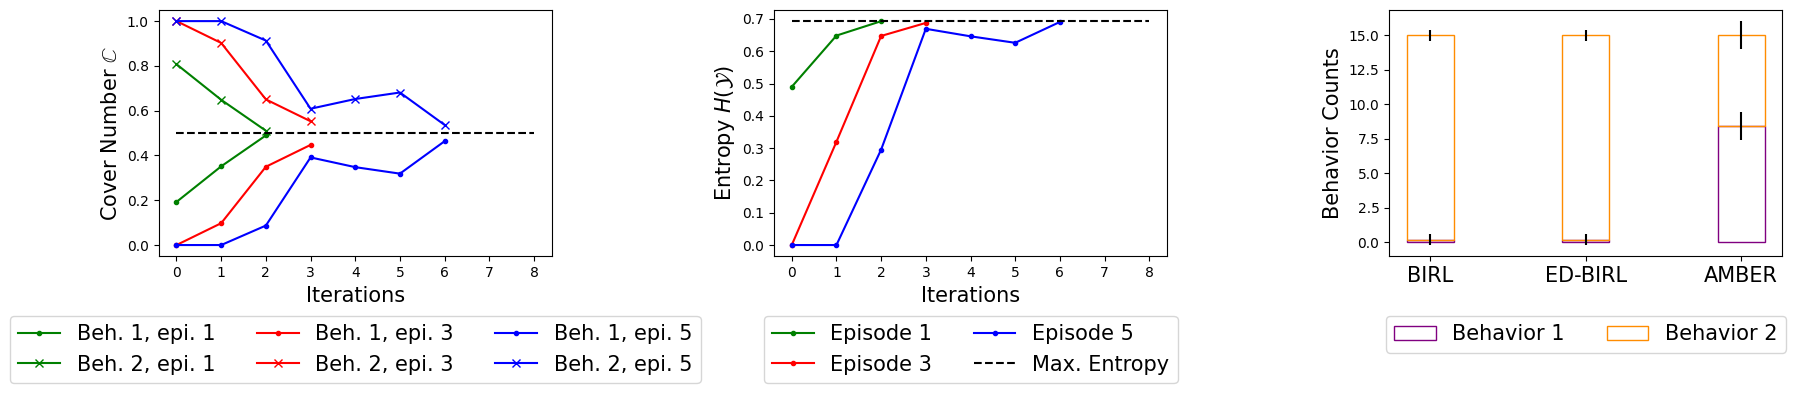

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
fontsize = 15
yshift_legend = 0.2

axs[0].plot(cov_numbers_episode_1[0], "g.-", label="Beh. 1, epi. 1")
axs[0].plot(cov_numbers_episode_1[1], "g-x", label="Beh. 2, epi. 1")
axs[0].plot(cov_numbers_episode_3[0], "r.-", label="Beh. 1, epi. 3")
axs[0].plot(cov_numbers_episode_3[1], "r-x", label="Beh. 2, epi. 3")
axs[0].plot(cov_numbers_episode_5[0], "b.-", label="Beh. 1, epi. 5")
axs[0].plot(cov_numbers_episode_5[1], "b-x", label="Beh. 2, epi. 5")
axs[0].set_xlabel("Iterations", size=fontsize)
axs[0].set_ylabel("Cover Number $\mathbb{C}$", size=fontsize)
axs[0].hlines(0.5, 0, 8, colors="black", linestyles="dashed")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -yshift_legend), ncols = 3, fontsize=fontsize)

axs[1].plot(entropies_episode_1, "g.-", label="Episode 1")
axs[1].plot(entropies_episode_3, "r.-", label="Episode 3")
axs[1].plot(entropies_episode_5, "b.-", label="Episode 5")
axs[1].set_xlabel("Iterations", size=fontsize)
axs[1].set_ylabel("Entropy $H(\mathcal{Y})$", size=fontsize)
axs[1].hlines(max_entropy, 0, 8, colors="black", linestyles="dashed", label = "Max. Entropy")
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -yshift_legend), ncols = 2, fontsize=fontsize)

mean_1 = [mean_behavior_1_BIRL, mean_behavior_1_EDBIRL, mean_behavior_1_amber]
mean_2 = [mean_behavior_2_BIRL, mean_behavior_2_EDBIRL, mean_behavior_2_amber]
yerr_1 = [std_behavior_1_BIRL, std_behavior_1_EDBIRL, std_behavior_1_amber]
yerr_2 = [std_behavior_2_BIRL, std_behavior_2_EDBIRL, std_behavior_2_amber]
axs[2].bar([1, 2, 3], mean_1, yerr=yerr_1, color="blue", label="Behavior 1", width=0.3, fill=False, edgecolor="purple")
axs[2].bar([1, 2, 3], mean_2, yerr=yerr_2, color="red", label="Behavior 2", bottom=mean_1, width=0.3, fill=False, edgecolor="darkorange")
axs[2].set_xticks([1, 2, 3])
axs[2].set_xticklabels(["BIRL", "ED-BIRL", "AMBER"], size=fontsize)
axs[2].set_ylabel("Behavior Counts", size=fontsize)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -yshift_legend), ncols = 2, fontsize=fontsize)

fig.tight_layout()

fig.tight_layout()

## Example Behavior Map

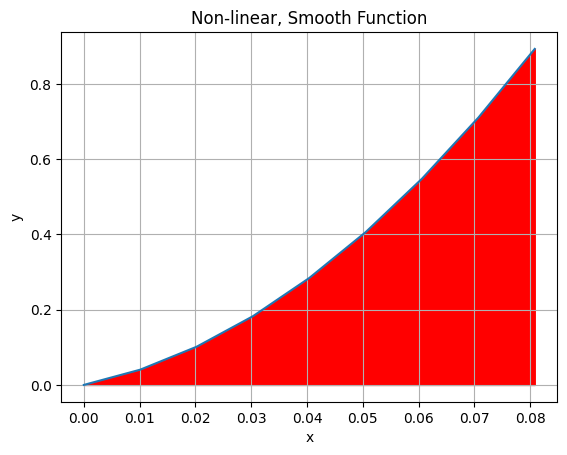

In [186]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 100)
y = np.sin(3*x) + 100*x**2  # You can replace this with any non-linear function you want
mask = (y >= 0) & (y <= 1)
y = y[mask]
x = x[mask]
binary_array = np.where(y > 0, 1, 0)

plt.plot(x, y)
plt.fill_between(x, y, color='red', where=(y >= 0), interpolate=True)
plt.fill_between(x, y, color='blue', where=(y <= 0), interpolate=True)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Non-linear, Smooth Function')
plt.grid(True)


